In [3]:
#Import csv file from DSPM website, label column names and parse date format:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
sales=pd.read_csv("http://liacs.leidenuniv.nl/~takesfw/DSPM/data/sales.csv", names=["saleId", "saleDateTime", "accountName", "coins", "currency", "priceInCurrency", "priceInEUR", "methodId", "ip", "ipCountry"], parse_dates=["saleDateTime"])

In [4]:
#Sort original csv file dates
sales = sales.sort_values(["saleDateTime"])
split1 = sales['saleDateTime'] < '2014-01-01 00:00:00'
sales14 = sales[split1]
split2 = sales['saleDateTime'] > '2013-12-31 23:59:59'
sales15 = sales[split2]

In [5]:
#Define function that returns boolean that shows if frequenty of purchases goes up
def func(x):
    q = True
    if x.iloc[0]['First'] < x.iloc[0]['Last']:
        q = False
    
    return q

In [6]:
#Favorite Countries:
sales["ipCountry"].value_counts().head(5)
fav_countries = ["FR","DE","PL","GP","NL"]
sales["methodId"].value_counts().head(3)
fav_paymethods = [2000,1000,40]

In [7]:
#Create 'customers' DF
customers = pd.DataFrame()
#First feature
customers['countries'] = sales14.groupby("accountName")["ipCountry"].nunique()

In [8]:
#Second feature
customers['lifespan'] = sales14.groupby("accountName")["saleDateTime"].max() - sales14.groupby("accountName")["saleDateTime"].min()
customers['lifespan'] = customers["lifespan"].dt.total_seconds()


In [9]:
#Third feature
customers['lifetime_spend'] = sales14.groupby("accountName")["priceInEUR"].sum()

In [10]:
#Fourth feature
customers['lifetime_trans'] = sales14.groupby("accountName")["saleId"].nunique()

In [11]:
#Fifth feature
tempx = sales14.groupby("accountName")["ipCountry"].value_counts()
temp5 = tempx.groupby("accountName").idxmax()

customers['fav_country'] = pd.Series({item[0]: item[1] for item in temp5}).isin(fav_countries)
customers['fav_country'] = customers['fav_country'].fillna(0)
customers['fav_country'] = customers['fav_country'].astype(int)

In [12]:
#Sixth feature
tempy = sales14.groupby("accountName")["methodId"].value_counts()
temp6 = tempy.groupby("accountName").idxmax()
customers['fav_paymethod'] = pd.Series({item[0]: item[1] for item in temp6}).isin(fav_paymethods)
customers['fav_paymethod'] = customers['fav_paymethod'].fillna(0)
customers['fav_paymethod'] = customers['fav_paymethod'].astype(int)

In [13]:
#Seventh feature
first = sales14.groupby("accountName")["saleDateTime"].nsmallest(2)
last = sales14.groupby("accountName")["saleDateTime"].nlargest(2)
df = pd.DataFrame()
df['First'] = abs(first.diff().reset_index().groupby("accountName").tail(1).set_index("accountName")["saleDateTime"].dt.days)
df['Last'] = abs(last.diff().reset_index().groupby("accountName").tail(1).set_index("accountName")["saleDateTime"].dt.days)
customers["freq_growth"] = df.groupby("accountName").apply(func)
customers["freq_growth"] = customers["freq_growth"].astype(int)

In [14]:
#Eighth feature
trans_growth = {}
for account, group in sales14.groupby('accountName')["priceInEUR"]:
    if group.shape[0] >= 2:
        trans_growth[account] = group.head(2).sum() < group.tail(2).sum()
customers["trans_growth"] = pd.Series(trans_growth)

customers["trans_growth"] = customers["trans_growth"].fillna(0)
customers["trans_growth"] = customers["trans_growth"].astype(int)

In [15]:
#Class feature: Does the customer return, set all to false
loyal = {}
customers["class"] = True
for account, group in customers.groupby('accountName')["class"]:
    if (account in sales15["accountName"].values):
        loyal[account] = True
    else:
        loyal[account] = False
customers["class"] = pd.Series(loyal)
customers["class"] = customers["class"].astype(int)

,countries,lifespan,lifetime_spend,lifetime_trans,fav_country,fav_paymethod,freq_growth,trans_growth,class
countries,1.000000,0.120854,0.161716,0.294982,0.001643,0.070054,-0.077231,0.143533,0.074937
lifespan,0.120854,1.000000,0.452776,0.344214,0.018446,-0.010099,-0.106917,0.215608,0.195295
lifetime_spend,0.161716,0.452776,1.000000,0.654994,0.012161,-0.038620,-0.104264,0.209986,0.123900
lifetime_trans,0.294982,0.344214,0.654994,1.000000,0.015811,0.087585,-0.136387,0.196263,0.157330
fav_country,0.001643,0.018446,0.012161,0.015811,1.000000,-0.102098,0.002590,0.059717,0.084557
fav_paymethod,0.070054,-0.010099,-0.038620,0.087585,-0.102098,1.000000,-0.040901,0.018092,0.052796
freq_growth,-0.077231,-0.106917,-0.104264,-0.136387,0.002590,-0.040901,1.000000,-0.149283,-0.032929
trans_growth,0.143533,0.215608,0.209986,0.196263,0.059717,0.018092,-0.149283,1.000000,0.105978
class,0.074937,0.195295,0.123900,0.157330,0.084557,0.052796,-0.032929,0.105978,1.000000


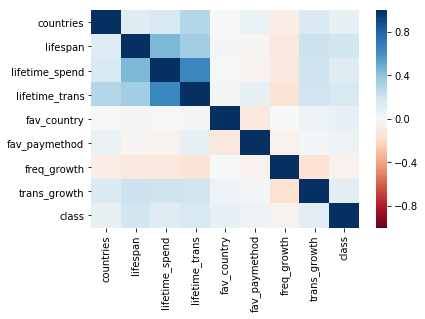

In [36]:
#Finding the 'best' features, based on insight of a correlation matrix, Chi squared method and inbuilt class feature_importances of tree based classifiers
#First correlation matrix
corr = customers.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,vmin=-1,vmax=1,cmap="RdBu")
corr

In [37]:
#Secondly show best features based on Chi2 selector
data = customers
X = customers.iloc[:,0:8]  #independent features
Y = customers.iloc[:,-1]   #target feature: class
#apply SelectKBest class to extract top 3 best features
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(3,'Score'))  #print 3 best features


            Specs         Score
1        lifespan  4.658707e+10
2  lifetime_spend  1.954931e+05
3  lifetime_trans  4.831898e+04


In [180]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X = customers.iloc[:,0:7]  #best features


X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

model = LogisticRegression()
model.fit(X_train,y_train)

/home/twumi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [181]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [182]:
model.score(X_test,y_test)

0.866558089033659

In [57]:
model.predict_proba(X_test)

array([[0.50682167, 0.49317833],
       [0.70501093, 0.29498907],
       [0.5       , 0.5       ],
       ...,
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ]])

#Show best features based on the scilearn inbuilt feature importance classifier
model = ExtraTreesClassifier()
model
model.fit(X,Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(3).plot(kind='barh')
ax.set(xlabel="Score (0 to 1)", ylabel="Feature Name")
plt.show()

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c

#set data to most important
X = customers.iloc[:,1:4]  #independent features
y = customers.iloc[:,-1]   #target feature: class

X /= X.max()  # Normalize X to speed-up convergence

cs = l1_min_c(X, Y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

In [185]:
from sklearn import tree
from sklearn import metrics
from sklearn.externals.six import StringIO
from IPython.display import Image

import graphviz 
X = customers.iloc[:,0:7]  #independent features
Y = customers.iloc[:,-1]   #target feature: class

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)


clf = tree.DecisionTreeClassifier(criterion="gini", max_leaf_nodes=8)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test,y_pred)

#dot_data = tree.export_graphviz(clf, out_file=None,  
#                     filled=True, rounded=True,  
#                     special_characters=True)  
#graph = graphviz.Source(dot_data)  
#graph

0.8639522258414767

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X = customers.iloc[0:1000,1:3]  #independent features
y = customers.iloc[0:1000,-1]   #target feature: class

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


model = svm.SVC(kernel='linear', C=1.0)
model.fit(X_train,y_train)

In [ ]:
model.predict(X_test)
model.score(X_test, y_test)

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X = customers.iloc[:,0:3]  #independent features
y = customers.iloc[:,-1]   #target feature: class

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

nn=MLPClassifier()
nn.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [22]:
nn.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
nn.score(X_test,y_test)

0.8668838219326819